In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [61]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../test-data/positions_xyz_full_new.csv')
dataCoordinates = pd.read_csv('../test-data/red_ball_coordinates_full_new.csv')
dataPositions.shape, dataCoordinates.shape

((3281, 3), (3281, 14))

In [62]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values
combined = combined.dropna(thresh=combined.shape[1]-3)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
13,2.500000,26.500000,45.0,25.5,0.500000,49.500000,24.500000,47.500000,46.5,47.5,NaN,NaN,34.5,59.50,9.819219,4.419736,16.34974
14,2.500000,27.000000,45.0,25.5,0.500000,49.500000,24.500000,47.500000,46.5,47.5,NaN,NaN,34.5,59.50,9.772747,4.508276,16.43828
15,3.500000,27.500000,45.0,26.5,0.800000,49.400000,24.666667,47.666667,47.0,47.5,NaN,NaN,34.5,59.50,9.723351,4.595220,16.52522
16,3.800000,27.600000,45.5,27.0,0.714286,50.428571,25.000000,48.000000,47.0,48.0,NaN,NaN,34.5,59.50,9.671085,4.680469,16.61047
17,4.333333,27.666667,46.0,27.0,1.600000,49.800000,25.000000,48.000000,47.5,48.5,NaN,NaN,34.5,59.50,9.616007,4.763927,16.69393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,3.500000,35.333333,44.2,32.8,0.500000,57.500000,21.888889,52.555556,45.8,55.6,NaN,NaN,34.5,59.75,10.140000,6.070000,16.50229
3226,3.285714,35.428571,44.0,33.0,0.500000,57.500000,21.142857,52.285714,45.8,55.6,NaN,NaN,34.5,59.75,10.140000,6.070000,16.41491
3227,3.500000,35.500000,43.8,33.6,0.333333,57.666667,21.142857,52.285714,45.8,55.6,NaN,NaN,34.5,59.75,10.140000,6.070000,16.32596
3228,3.285714,35.428571,44.0,33.5,0.333333,57.666667,21.142857,52.285714,45.8,55.6,NaN,NaN,34.5,59.75,10.140000,6.070000,16.23554


In [63]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

In [64]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
dfX = imputer.fit_transform(X)
y = imputer.fit_transform(y)

### Splitting the dataset into the Training set and Test set

In [65]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [66]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(998, 333, 333)

### Hyperparameter tuning

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (150,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])
model = MLPRegressor(random_state=42, solver='sgd', max_iter=20000, learning_rate_init=0.1, learning_rate='adaptive', hidden_layer_sizes=(150,), early_stopping=True, activation='relu')
# Perform a randomized search over the parameter grid
#random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [68]:
model.fit(X_train_scaled, y_train_scaled)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(150,),
             learning_rate='adaptive', learning_rate_init=0.1, max_iter=20000,
             random_state=42, solver='sgd')

#### Result of the hyperparameter tuning

In [69]:
#model = random_search.best_estimator_

In [70]:
#print('fBest parameters found:\n', random_search.best_params_)

#### Make Predictions

In [71]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [72]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.044118962078742045
Mean Absolute Error on Validation Set: 0.1045334409309127
R2 Score on Validation set: 0.9801581512847646


In [73]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [74]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.029728463358287428
Mean Absolute Error on Test Set: 0.09051040305714277
R2 Score on Test set: 0.9884785939768448


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

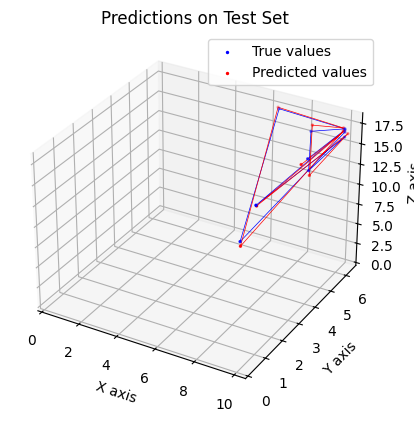

In [75]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [76]:
test_data = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_13h38m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../test-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',', decimal='.')

In [77]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna(thresh=new_combined.shape[1]-3)
new_combined = new_combined

In [78]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((896, 14), (896, 3))

In [79]:
new_X_imputed = imputer.fit_transform(new_X)

new_X_scaled = scaler_X.fit_transform(new_X_imputed)
new_y_scaled = scaler_y.fit_transform(new_y)

In [80]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [81]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [82]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 2.625593883272955
Mean Absolute Error on New Data Set: 1.2052263821318305
R2 Score on New Data set: 0.36734647179881624


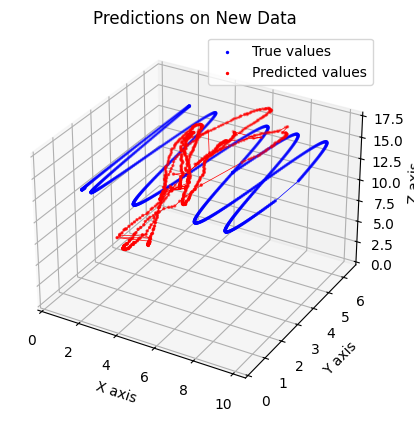

In [83]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")